In [2]:
# ==========================================
# SECTION 1: LIBRARIES & CONFIGURATION
# ==========================================
import os
import time
import random
import ast
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns  # Bổ sung seaborn để vẽ đẹp hơn

# PyTorch Ecosystem
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Tắt warning
warnings.filterwarnings('ignore')

# CONFIGURATION
CONFIG = {
    "seed": 2024,
    "image_size": 256,      
    "batch_size": 32,       
    "num_epochs": 25,       
    "learning_rate": 3e-4,  
    "num_classes": 8,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "num_workers": 2,
    "patience": 5,
    "model_name": "convnext_base" # Đặt tên model ở đây để dễ quản lý
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(CONFIG['seed'])
print(f"🔥 Running on: {CONFIG['device']} | Model: {CONFIG['model_name']} | Image Size: {CONFIG['image_size']}")



🔥 Running on: cpu | Model: convnext_base | Image Size: 256


📂 Found CSV: /kaggle/input/ati-topic3/topic3/label_images.csv


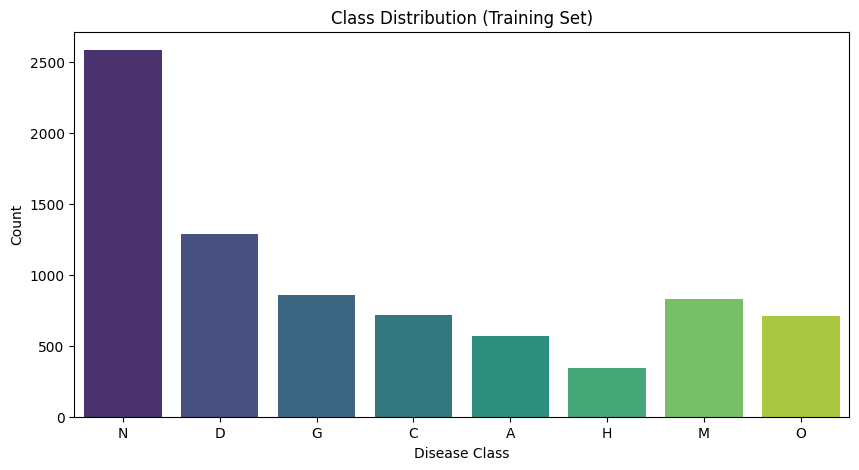

⚖️ Class Weights: tensor([0.3819, 0.7673, 1.1514, 1.3743, 1.7434, 2.8685, 1.1903, 1.3898],
       device='cuda:0')
🔄 Loading 7894 images to RAM...


  0%|          | 0/7894 [00:00<?, ?it/s]

🔄 Loading 1974 images to RAM...


  0%|          | 0/1974 [00:00<?, ?it/s]

👀 Visualizing Augmented Samples...


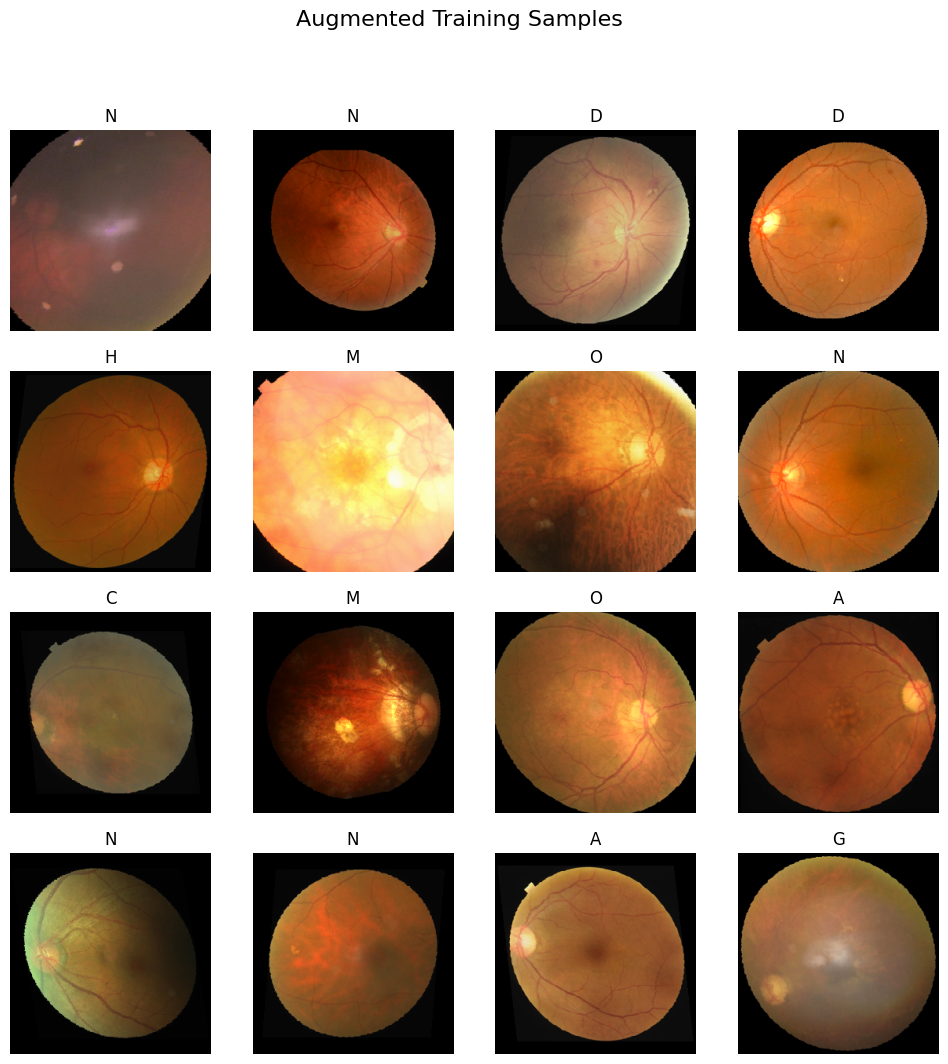

In [37]:
# ==========================================
# SECTION 2: DATA PREPARATION & VISUALIZATION
# ==========================================
def find_data_paths():
    paths_to_check = [Path('/kaggle/input'), Path('/content'), Path('.')]
    for base in paths_to_check:
        csv_files = list(base.rglob('label_images.csv'))
        if csv_files:
            csv_path = csv_files[0]
            img_dir = csv_path.parent / 'images'
            if not img_dir.exists():
                img_dirs = [p for p in csv_path.parent.rglob('images') if p.is_dir()]
                if img_dirs: img_dir = img_dirs[0]
            return csv_path, img_dir
    # Fallback path (Hardcode)
    return '/kaggle/input/topic3/topic3/label_images.csv', '/kaggle/input/topic3/topic3/images'

# 1. Load Data
try:
    CSV_PATH, IMAGE_DIR = find_data_paths()
    print(f"📂 Found CSV: {CSV_PATH}")
except Exception as e:
    print(f"⚠️ Error finding paths: {e}")

df = pd.read_csv(CSV_PATH)

def parse_label(label_str):
    try:
        if isinstance(label_str, str):
            res = ast.literal_eval(label_str)
            return res[0] if isinstance(res, list) and res else None
    except: return None
    return None

df['disease_class'] = df['label'].apply(parse_label)
df = df.dropna(subset=['disease_class'])

class_map = {'N': 0, 'D': 1, 'G': 2, 'C': 3, 'A': 4, 'H': 5, 'M': 6, 'O': 7}
inv_class_map = {v: k for k, v in class_map.items()}
df['class_idx'] = df['disease_class'].map(class_map)
df['file_path'] = df['images'].apply(lambda x: os.path.join(IMAGE_DIR, x))

# 2. Stratified Split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['class_idx'], random_state=CONFIG['seed'])

# 3. [NEW] Visualize Data Distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=train_df, x='disease_class', order=class_map.keys(), palette='viridis')
plt.title('Class Distribution (Training Set)')
plt.xlabel('Disease Class')
plt.ylabel('Count')
plt.show()

# 4. Compute Class Weights
weights = compute_class_weight('balanced', classes=np.unique(train_df['class_idx']), y=train_df['class_idx'])
class_weights = torch.tensor(weights, dtype=torch.float).to(CONFIG['device'])
print("⚖️ Class Weights:", class_weights)

# 5. Dataset Class
class InMemoryDataset(Dataset):
    def __init__(self, df, img_size, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.data = []
        self.labels = []
        
        print(f"🔄 Loading {len(df)} images to RAM...")
        for _, row in tqdm(self.df.iterrows(), total=len(self.df)):
            try:
                img = Image.open(row['file_path']).convert('RGB')
                img = img.resize((img_size, img_size)) 
                self.data.append(img)
                self.labels.append(row['class_idx'])
            except:
                self.data.append(Image.new('RGB', (img_size, img_size)))
                self.labels.append(row['class_idx'])
                
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        img = self.data[idx]
        if self.transform: img = self.transform(img)
        return img, torch.tensor(self.labels[idx], dtype=torch.long)

# Transforms
train_ops = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_ops = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Loaders
train_ds = InMemoryDataset(train_df, CONFIG['image_size'], transform=train_ops)
val_ds = InMemoryDataset(val_df, CONFIG['image_size'], transform=val_ops)

train_loader = DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers'])
val_loader = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'])

# 6. [NEW] Visualize Sample Batch
def show_batch(loader):
    imgs, labels = next(iter(loader))
    plt.figure(figsize=(12, 12))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        # Un-normalize để hiển thị ảnh gốc
        img = imgs[i].permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        plt.imshow(img.clip(0, 1))
        plt.title(inv_class_map[labels[i].item()])
        plt.axis("off")
    plt.suptitle("Augmented Training Samples", fontsize=16)
    plt.show()

print("👀 Visualizing Augmented Samples...")
show_batch(train_loader)


In [38]:
# ==========================================
# SECTION 3: MODEL CONSTRUCTION
# ==========================================
def build_model(num_classes, model_name='convnext_base'):
    print(f"🔄 Building model: {model_name}...")
    
    if model_name == 'convnext_base':
        model = models.convnext_base(weights='DEFAULT')
        in_features = model.classifier[2].in_features
        model.classifier[2] = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    else:
        # Fallback to ResNet50 if needed
        model = models.resnet50(weights='DEFAULT')
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    
    return model

model = build_model(CONFIG['num_classes'], CONFIG['model_name']).to(CONFIG['device'])

optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2)
scaler = torch.cuda.amp.GradScaler()

🔄 Building model: convnext_base...


In [39]:
# ==========================================
# SECTION 4: TRAINING LOOP WITH HISTORY
# ==========================================
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_f1, model, path):
        score = val_f1
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_f1, model, path)
        elif score < self.best_score:
            self.counter += 1
            print(f'   ⏳ EarlyStopping: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_f1, model, path)
            self.counter = 0

    def save_checkpoint(self, val_f1, model, path):
        torch.save(model.state_dict(), path)
        print(f'   🔥 Model Improved (F1: {val_f1:.4f}) -> Saved!')

def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    pbar = tqdm(loader, desc="Training", leave=False)
    for imgs, labels in pbar:
        imgs, labels = imgs.to(CONFIG['device']), labels.to(CONFIG['device'])
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})
    return total_loss / len(loader)

def val_epoch(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(CONFIG['device']), labels.to(CONFIG['device'])
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    f1 = f1_score(all_labels, all_preds, average='macro')
    return total_loss/len(loader), f1

# Training Variables
history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
early_stopper = EarlyStopping(patience=CONFIG['patience'])
SAVE_PATH = 'best_model.pth'

print("\n🚀 START TRAINING...")
for epoch in range(CONFIG['num_epochs']):
    start = time.time()
    
    train_loss = train_epoch(model, train_loader, optimizer)
    val_loss, val_f1 = val_epoch(model, val_loader)
    
    # Update History
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)
    
    scheduler.step(val_loss)
    lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch {epoch+1:02d} | LR: {lr:.1e} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")
    
    early_stopper(val_f1, model, SAVE_PATH)
    if early_stopper.early_stop:
        print("🛑 Early Stopping triggered.")
        break

print("\n✅ TRAINING COMPLETED.")



🚀 START TRAINING...


Training:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 01 | LR: 3.0e-04 | Train Loss: 1.7738 | Val Loss: 1.5069 | Val F1: 0.5048
   🔥 Model Improved (F1: 0.5048) -> Saved!


Training:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 02 | LR: 3.0e-04 | Train Loss: 1.4422 | Val Loss: 1.3721 | Val F1: 0.5335
   🔥 Model Improved (F1: 0.5335) -> Saved!


Training:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 03 | LR: 3.0e-04 | Train Loss: 1.3489 | Val Loss: 1.2612 | Val F1: 0.6167
   🔥 Model Improved (F1: 0.6167) -> Saved!


Training:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 04 | LR: 3.0e-04 | Train Loss: 1.2943 | Val Loss: 1.2727 | Val F1: 0.6273
   🔥 Model Improved (F1: 0.6273) -> Saved!


Training:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 05 | LR: 3.0e-04 | Train Loss: 1.2551 | Val Loss: 1.1817 | Val F1: 0.6984
   🔥 Model Improved (F1: 0.6984) -> Saved!


Training:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 06 | LR: 3.0e-04 | Train Loss: 1.2250 | Val Loss: 1.1598 | Val F1: 0.7003
   🔥 Model Improved (F1: 0.7003) -> Saved!


Training:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 07 | LR: 3.0e-04 | Train Loss: 1.1938 | Val Loss: 1.2148 | Val F1: 0.6692
   ⏳ EarlyStopping: 1/5


Training:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 08 | LR: 3.0e-04 | Train Loss: 1.1822 | Val Loss: 1.1451 | Val F1: 0.7282
   🔥 Model Improved (F1: 0.7282) -> Saved!


Training:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 09 | LR: 3.0e-04 | Train Loss: 1.1438 | Val Loss: 1.2160 | Val F1: 0.7086
   ⏳ EarlyStopping: 1/5


Training:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 10 | LR: 3.0e-04 | Train Loss: 1.1327 | Val Loss: 1.1215 | Val F1: 0.7247
   ⏳ EarlyStopping: 2/5


Training:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 11 | LR: 3.0e-04 | Train Loss: 1.1033 | Val Loss: 1.1439 | Val F1: 0.7146
   ⏳ EarlyStopping: 3/5


Training:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 12 | LR: 3.0e-04 | Train Loss: 1.1004 | Val Loss: 1.1809 | Val F1: 0.6957
   ⏳ EarlyStopping: 4/5


Training:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 13 | LR: 6.0e-05 | Train Loss: 1.0763 | Val Loss: 1.1379 | Val F1: 0.7220
   ⏳ EarlyStopping: 5/5
🛑 Early Stopping triggered.

✅ TRAINING COMPLETED.


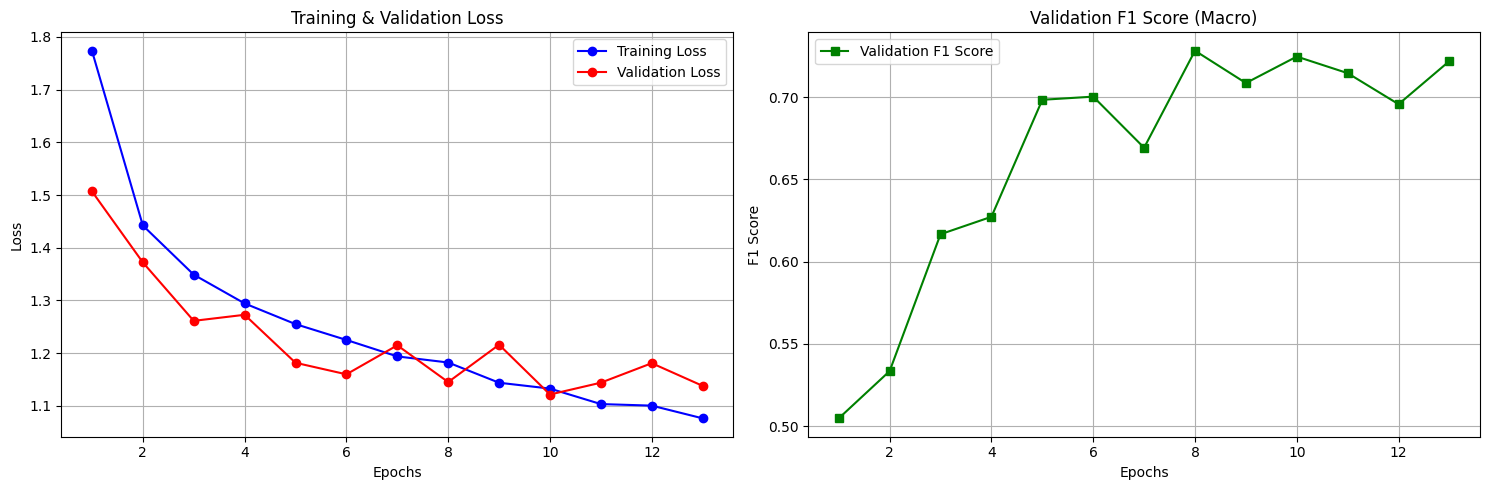

In [ ]:
# ==========================================
# SECTION 5: VISUALIZE TRAINING PROCESS
# ==========================================
# [NEW] Vẽ đồ thị Loss và F1
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], 'b-o', label='Training Loss')
plt.plot(epochs, history['val_loss'], 'r-o', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot F1 Score
plt.subplot(1, 2, 2)
plt.plot(epochs, history['val_f1'], 'g-s', label='Validation F1 Score')
plt.title('Validation F1 Score (Macro)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

🚀 Running TTA Evaluation...


  0%|          | 0/62 [00:00<?, ?it/s]


📑 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           N       0.73      0.75      0.74       646
           D       0.63      0.62      0.62       322
           G       0.87      0.76      0.81       214
           C       0.76      0.91      0.83       179
           A       0.70      0.70      0.70       142
           H       0.88      0.73      0.80        86
           M       0.93      0.91      0.92       207
           O       0.47      0.47      0.47       178

    accuracy                           0.73      1974
   macro avg       0.74      0.73      0.74      1974
weighted avg       0.73      0.73      0.73      1974

🏆 FINAL MACRO F1 SCORE: 0.7355


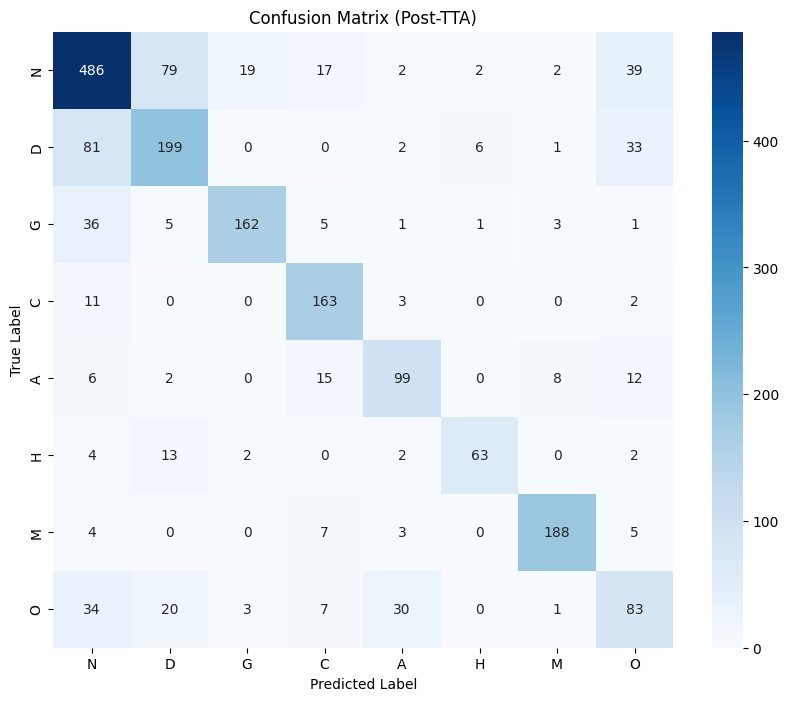

In [41]:

# ==========================================
# SECTION 6: EVALUATION & CONFUSION MATRIX
# ==========================================
def predict_tta(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    print("🚀 Running TTA Evaluation...")
    
    with torch.no_grad():
        for imgs, labels in tqdm(loader):
            imgs = imgs.to(CONFIG['device'])
            labels = labels.to(CONFIG['device'])
            
            # TTA: Original + Horizontal Flip + Vertical Flip
            out1 = model(imgs)
            out2 = model(torch.flip(imgs, [3])) 
            out3 = model(torch.flip(imgs, [2]))
            
            avg_out = (out1 + out2 + out3) / 3.0
            _, preds = torch.max(avg_out, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return all_labels, all_preds

# Load Best Model
model.load_state_dict(torch.load(SAVE_PATH))
y_true, y_pred = predict_tta(model, val_loader)

# Classification Report
target_names = [k for k, v in sorted(class_map.items(), key=lambda item: item[1])]
print("\n📑 CLASSIFICATION REPORT:")
print(classification_report(y_true, y_pred, target_names=target_names))

f1_final = f1_score(y_true, y_pred, average='macro')
print(f"🏆 FINAL MACRO F1 SCORE: {f1_final:.4f}")

# [NEW] Confusion Matrix Visualization
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix (Post-TTA)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:

# ==========================================
# SECTION 7: INFERENCE ON NEW DATA (DEMO)
# ==========================================
# [NEW] Hàm dự đoán ảnh mới
def predict_single_image(image_path, model):
    try:
        # Load & Preprocess
        img = Image.open(image_path).convert('RGB')
        img_resized = img.resize((CONFIG['image_size'], CONFIG['image_size']))
        img_t = val_ops(img_resized).unsqueeze(0).to(CONFIG['device'])
        
        # Predict
        model.eval()
        with torch.no_grad():
            output = model(img_t)
            probs = torch.nn.functional.softmax(output, dim=1)
            conf, pred_idx = torch.max(probs, 1)
            
        pred_label = inv_class_map[pred_idx.item()]
        confidence = conf.item() * 100
        
        # Visualize
        plt.figure(figsize=(4, 4))
        plt.imshow(img_resized)
        plt.title(f"Pred: {pred_label} ({confidence:.2f}%)")
        plt.axis('off')
        plt.show()
        
        return pred_label, confidence
    except Exception as e:
        print(f"❌ Error processing image: {e}")
        return None, None

print("\n🔎 TESTING INFERENCE ON A SAMPLE IMAGE:")
# Lấy ngẫu nhiên 1 ảnh từ tập Val để test
sample_row = val_df.sample(1).iloc[0]
sample_path = sample_row['file_path']
true_label = sample_row['disease_class']

print(f"Path: {sample_path}")
print(f"True Label: {true_label}")
predict_single_image(sample_path, model)